<a href="https://colab.research.google.com/github/ramdarsh/datascience_projects/blob/main/Wine_quality_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from imblearn.over_sampling import ADASYN, SMOTE, BorderlineSMOTE, RandomOverSampler
from sklearn.model_selection import  train_test_split,StratifiedKFold,cross_val_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, LinearRegression
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score,log_loss,classification_report,f1_score,precision_score,recall_score,make_scorer,cohen_kappa_score)
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight

%matplotlib inline

In [3]:
wine_data = pd.read_csv('/content/WineQT.csv')

In [4]:
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [5]:
df = wine_data.copy()
del df["Id"]
df["quality"] = df["quality"] - 3
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 107.3 KB


In [7]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [8]:
df.describe()[1:].style.background_gradient()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
mean,8.311111,0.531339,0.268364,2.532152,0.086933,15.615486,45.914698,0.996730,3.311015,0.657708,10.442111,2.657043
std,1.747595,0.179633,0.196686,1.355917,0.047267,10.250486,32.782130,0.001925,0.156664,0.170399,1.082196,0.805824
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,0.000000
25%,7.100000,0.392500,0.090000,1.900000,0.070000,7.000000,21.000000,0.995570,3.205000,0.550000,9.500000,2.000000
50%,7.900000,0.520000,0.250000,2.200000,0.079000,13.000000,37.000000,0.996680,3.310000,0.620000,10.200000,3.000000
75%,9.100000,0.640000,0.420000,2.600000,0.090000,21.000000,61.000000,0.997845,3.400000,0.730000,11.100000,3.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000,5.000000


In [9]:
df.nunique().sort_values(ascending=True)

quality                   6
free sulfur dioxide      53
alcohol                  61
citric acid              77
residual sugar           80
pH                       87
sulphates                89
fixed acidity            91
chlorides               131
volatile acidity        135
total sulfur dioxide    138
density                 388
dtype: int64

Text(0.5, 0.98, 'Visualizing columns')

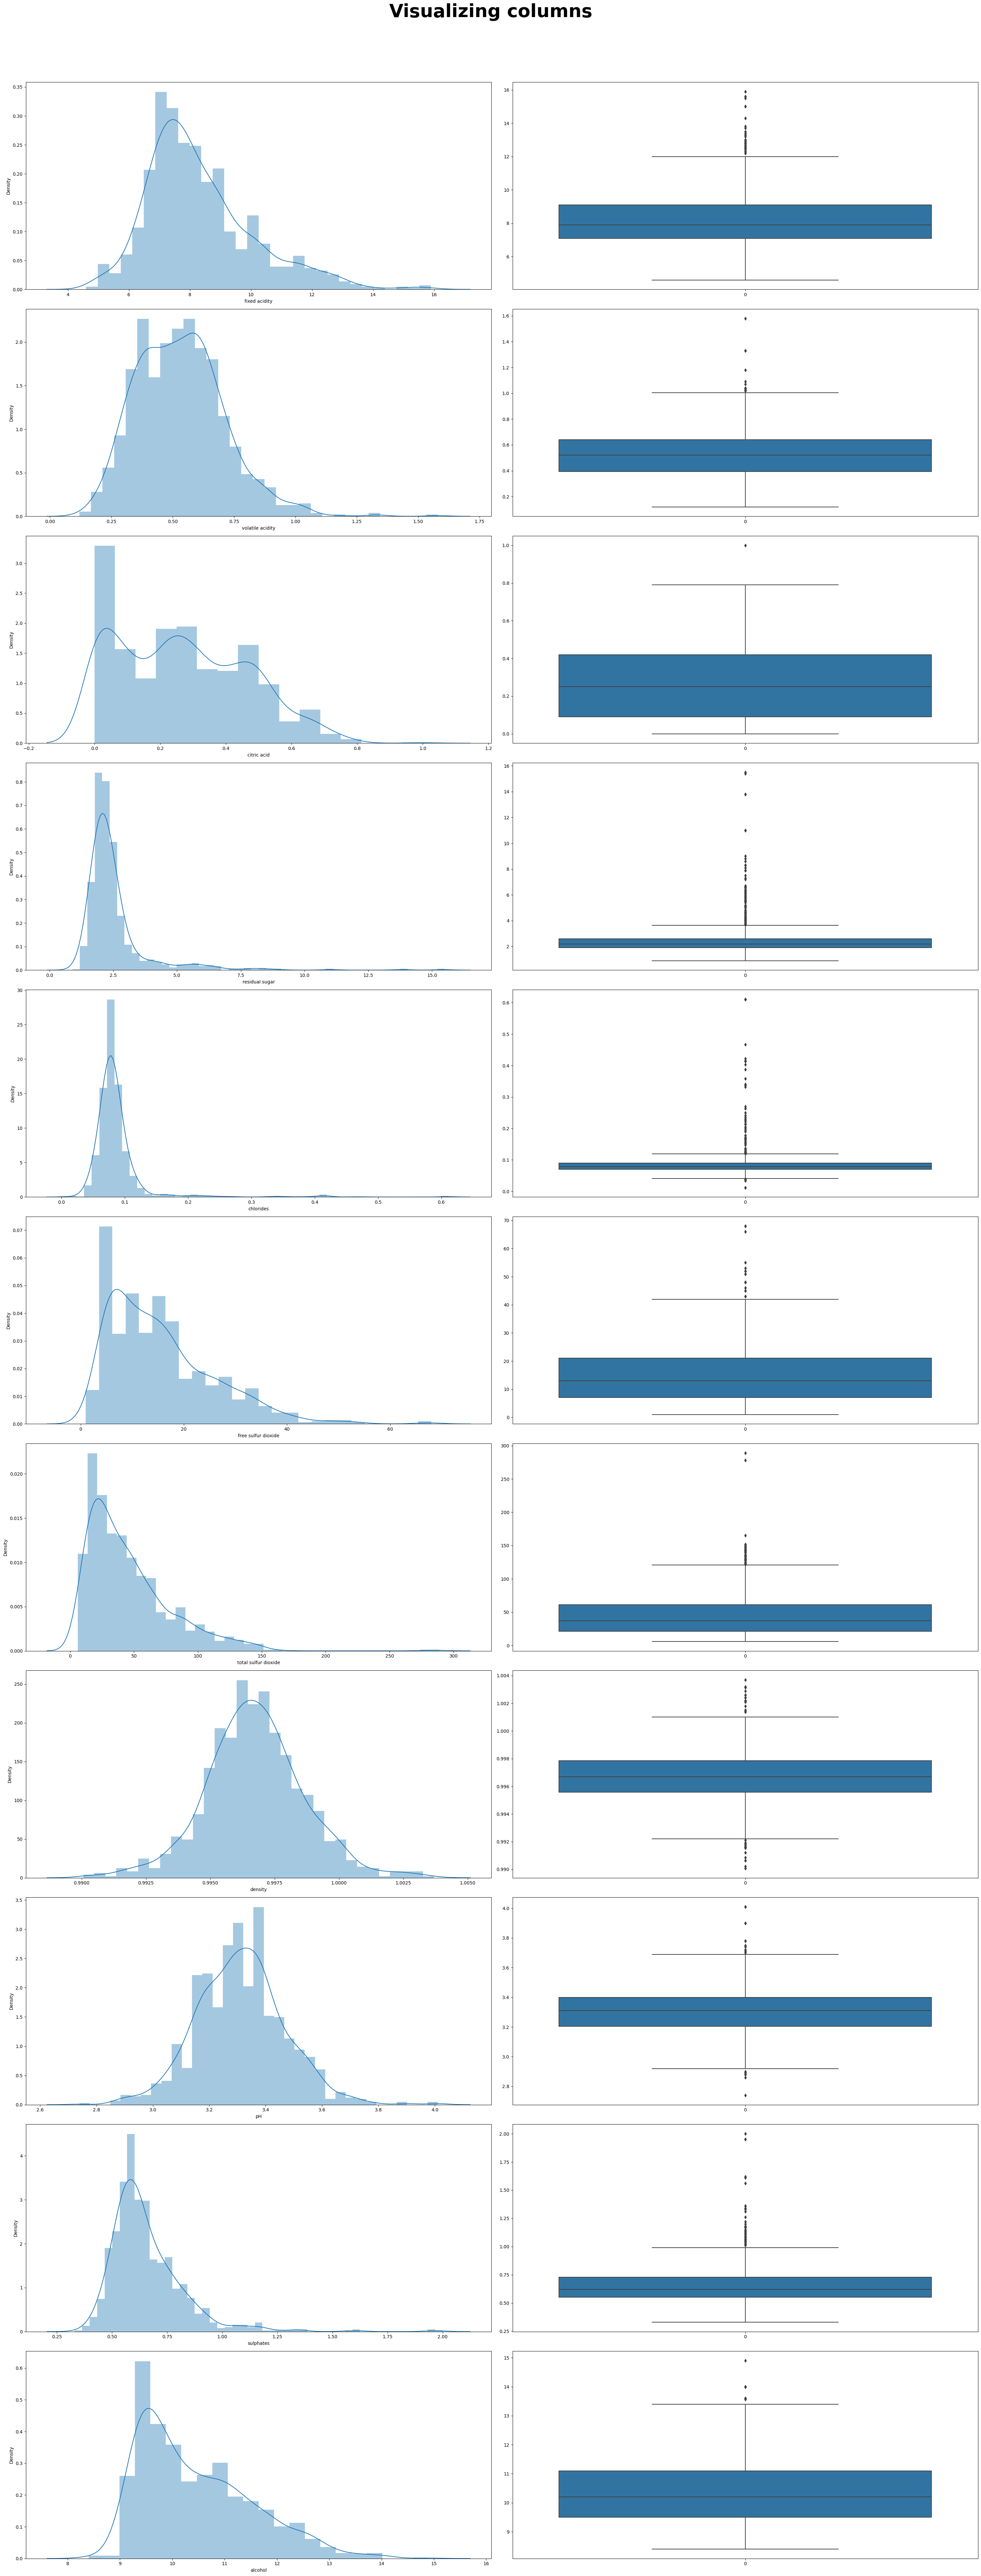

In [10]:
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(11, 2, figsize=(30, 80))
for index, i in enumerate(df.select_dtypes(include=["float64"]).columns):
    sns.distplot(df[i], ax=ax[index, 0])
    sns.boxplot(df[i], ax=ax[index, 1])

fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle("Visualizing columns", fontweight="bold", fontsize=40)

<Axes: xlabel='quality', ylabel='count'>

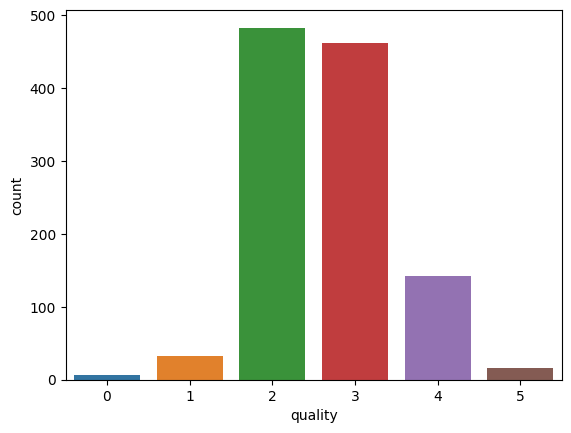

In [11]:
sns.countplot(data=df, x="quality")

In [12]:
fig = px.imshow(df.corr(), color_continuous_scale="Blues")
fig.update_layout(height=600)
fig.show()

visualizing the correlation

In [13]:
df_corr_bar = df.corr().quality.sort_values()[:-1]
fig = px.bar(df_corr_bar, orientation="h", color_discrete_sequence=["#722F37"])
fig.update_layout(showlegend=False)
fig.show()

In [14]:
X = df.drop(["quality"], axis=1)
y = df["quality"]

In [15]:
fs = SelectKBest(score_func=f_classif, k="all")
fs.fit(X, y)

feature_contribution = (fs.scores_ / sum(fs.scores_)) * 100

fixed acidity : 2.09%
volatile acidity : 23.23%
citric acid : 8.58%
residual sugar : 0.60%
chlorides : 1.79%
free sulfur dioxide : 1.31%
total sulfur dioxide : 7.40%
density : 4.14%
pH : 2.01%
sulphates : 8.75%
alcohol : 40.10%


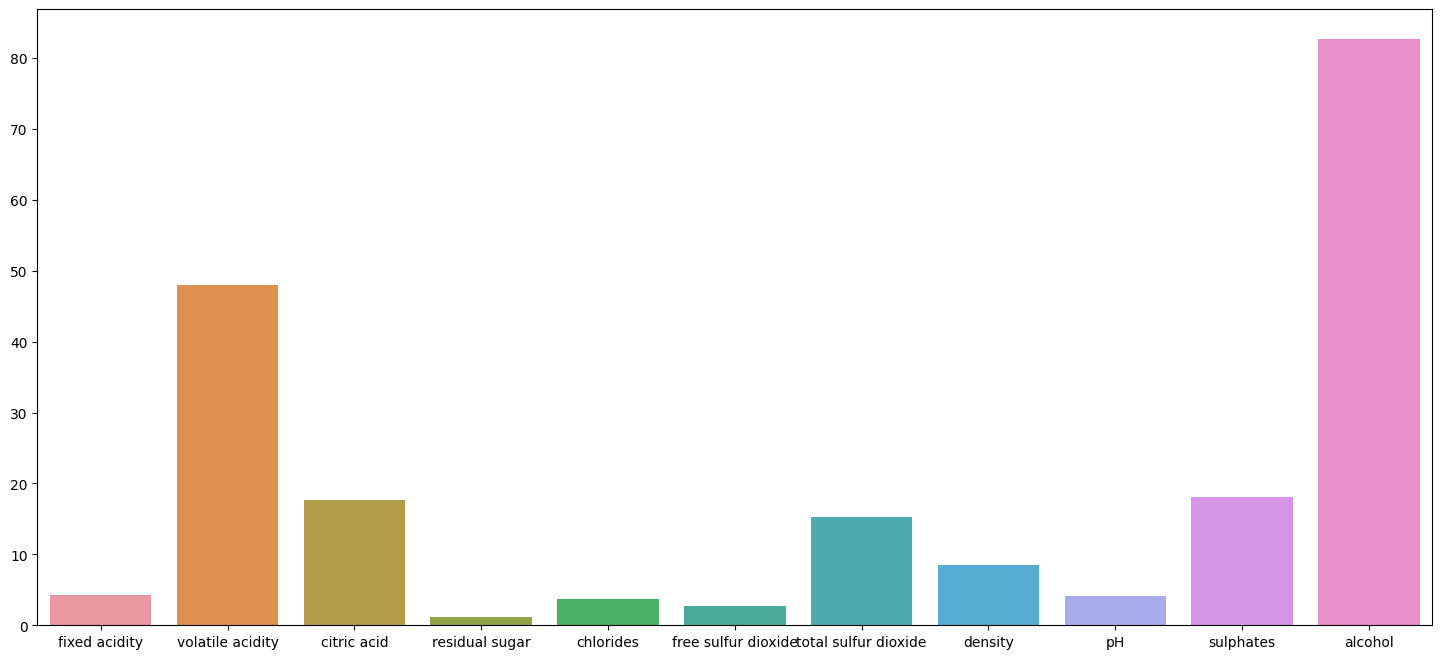

In [16]:
for i, j in enumerate(X.columns):
    print(f"{j} : {feature_contribution[i]:.2f}%")

plt.figure(figsize=(18, 8))
sns.barplot(x=X.columns, y=fs.scores_)
plt.show()

In [17]:
X_fs = X[
    [
        "volatile acidity",
        "citric acid",
        "total sulfur dioxide",
        "sulphates",
        "alcohol",
    ]
]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_fs, y, stratify=y, test_size=0.25, random_state=0)

<Axes: xlabel='quality', ylabel='count'>

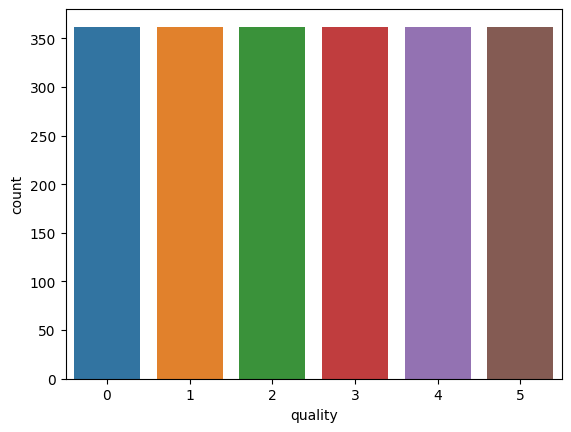

In [19]:
oversample = RandomOverSampler(random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
sns.countplot(data=X_train, x=y_train)

In [20]:
y_train.value_counts()

3    362
2    362
4    362
1    362
5    362
0    362
Name: quality, dtype: int64

In [21]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
models = [
    DecisionTreeClassifier(random_state=0),
    RandomForestClassifier(random_state=0),
    KNeighborsClassifier(),
    SVC(random_state=0),
    LogisticRegression(random_state=0),
    XGBClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),]
models_comparison = {}

for model in models:
    print(f"Model: {str(model)}\n")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5)
    print(classification_report(y_test, y_pred))
    print("-" * 30, "\n")
    models_comparison[f"{str(model)}"] = [
        accuracy_score(y_pred, y_test),
        f1_score(y_pred, y_test, average="macro"),
        precision_score(y_pred, y_test, average="macro"),
        recall_score(y_pred, y_test, average="macro"),
        (accuracies.mean()),]

Model: DecisionTreeClassifier(random_state=0)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.18      0.25      0.21         8
           2       0.70      0.71      0.70       121
           3       0.58      0.53      0.56       116
           4       0.34      0.39      0.36        36
           5       0.00      0.00      0.00         4

    accuracy                           0.57       286
   macro avg       0.30      0.31      0.31       286
weighted avg       0.58      0.57      0.58       286

------------------------------ 

Model: RandomForestClassifier(random_state=0)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.20      0.12      0.15         8
           2       0.72      0.82      0.77       121
           3       0.63      0.59      0.61       116
           4       0.36      0.33      0.35        36
     

In [23]:
models_com_df = pd.DataFrame(models_comparison).T
models_com_df.columns = [
    "Model Accuracy",
    "Model F1-Score",
    "Precision",
    "Recall",
    "CV Accuracy",
]
models_com_df = models_com_df.sort_values(by="Model F1-Score", ascending=False)
models_com_df.style.format("{:.2%}").background_gradient(cmap="Blues")

,Model Accuracy,Model F1-Score,Precision,Recall,CV Accuracy
RandomForestClassifier(random_state=0),63.64%,36.93%,35.36%,40.32%,88.58%
"XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, gpu_id=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, n_estimators=100, n_jobs=None, num_parallel_tree=None, objective='multi:softprob', predictor=None, ...)",61.54%,35.03%,34.54%,37.39%,87.52%
GradientBoostingClassifier(),55.24%,32.05%,31.36%,32.96%,86.88%
DecisionTreeClassifier(random_state=0),57.34%,30.59%,31.40%,30.03%,85.31%
SVC(random_state=0),43.71%,28.88%,48.72%,29.35%,67.54%
LogisticRegression(random_state=0),37.06%,24.29%,46.05%,27.43%,51.66%
KNeighborsClassifier(),43.71%,23.30%,24.60%,24.04%,80.57%
AdaBoostClassifier(),21.33%,17.13%,33.24%,16.11%,27.85%
